Previously, **neufrac** was tried as a metric to tell leptonJet's type (e/mu).
Could look at counts of mu candidates per leptonJet, this notebook is looking at this.

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import coffea.processor as processor

from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [22]:
class splitProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        match_axis = hist.Bin('match', 'match', 2, 0, 2)
        nmu_axis = hist.Bin('nmu', '#muon', 8, 0, 8)
        self._accumulator = processor.dict_accumulator({
            'nmu': hist.Hist('Counts', dataset_axis, match_axis, nmu_axis)
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ljdautype = NestNestObjArrayToJagged(df['pfjet_pfcand_type'])
        ljnmus = ((ljdautype==3)|(ljdautype==8)).astype(int).sum()
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
#             nmus=ljnmus.content,
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        output['nmu'].fill(dataset=dataset,
                           match=matchmask.astype(int).flatten(),
                           nmu=ljnmus.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [23]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=splitProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


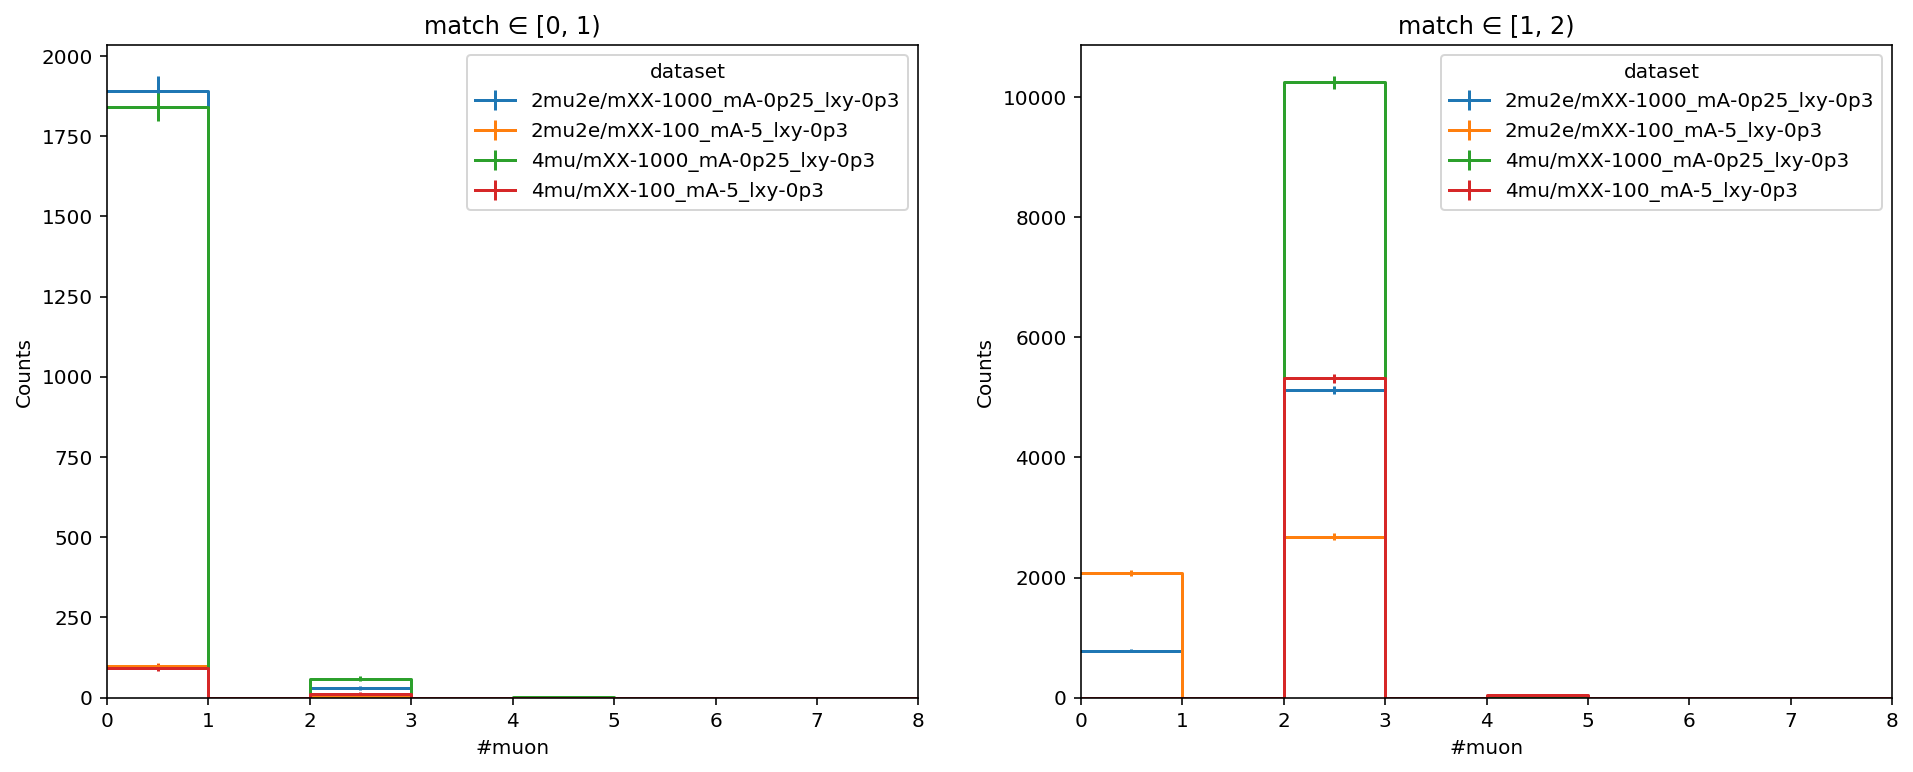

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
hist.plotgrid(output['nmu'], col='match', overlay='dataset', figure=fig);

- lxy:300cm

In [26]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=splitProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  1.92items/s]


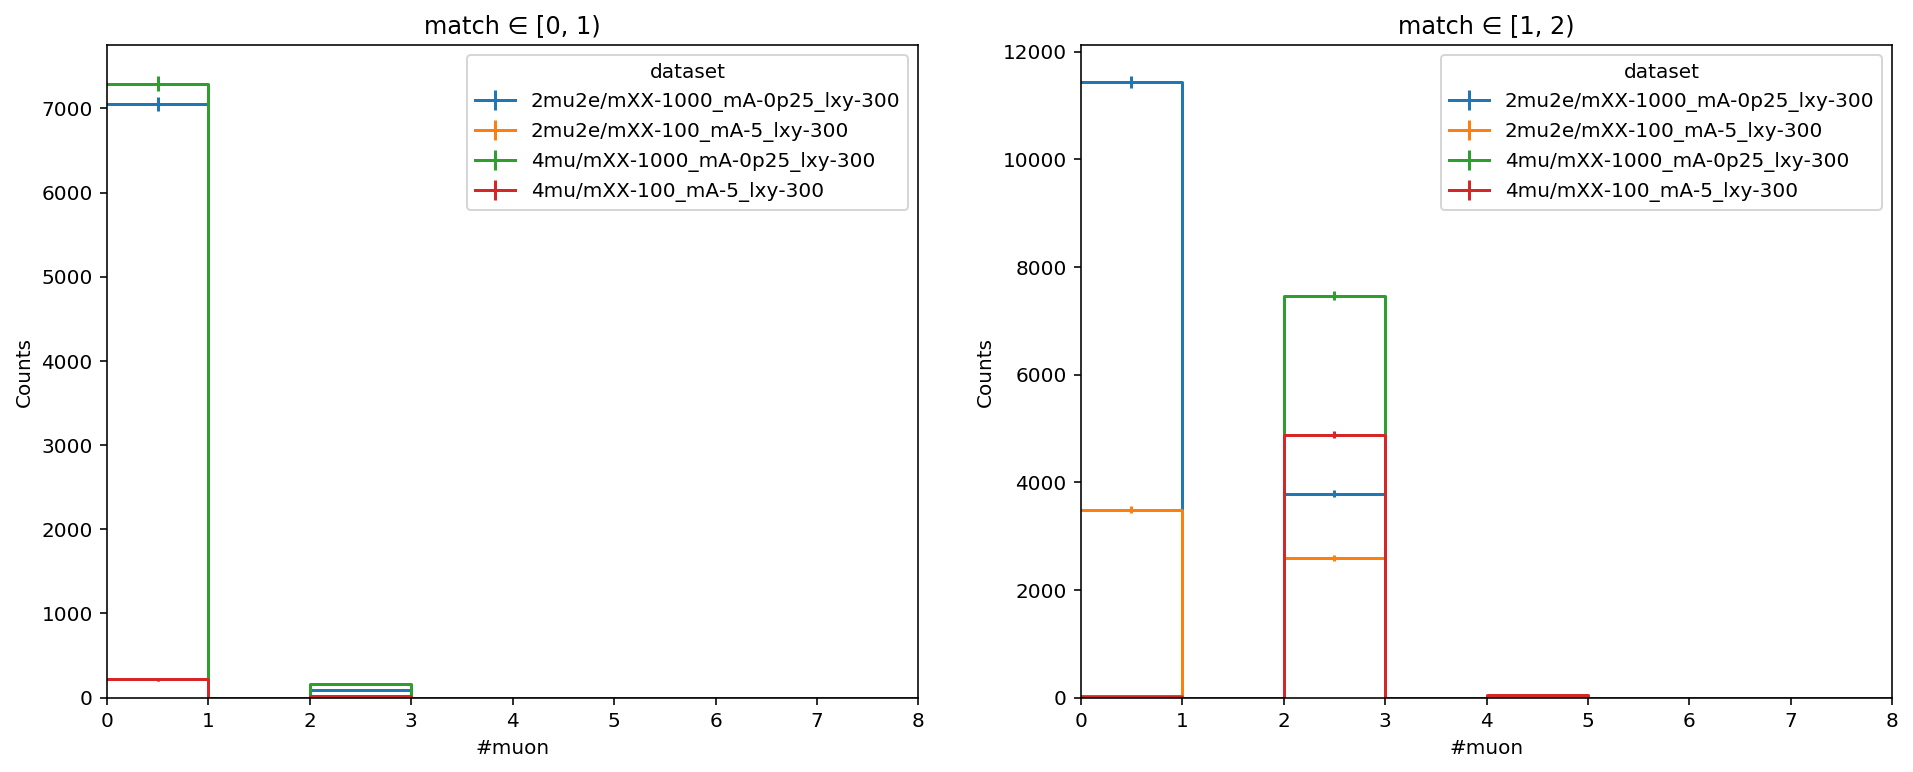

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
hist.plotgrid(output['nmu'], col='match', overlay='dataset', figure=fig);

should work